# Bounding Box Detectors for TensorFlow

Let's walk through how we can detect objects from images and draw bounding boxes around each object.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tonyreina/keras_tutorials/blob/master/bounding_box_detectors.ipynb)

# OpenCV

We'll use [OpenCV (computer vision)](https://opencv.org/) to draw some shapes over our image.

In [1]:
import numpy as np
import cv2  # OpenCV
import matplotlib.pyplot as plt

from typing import List

%matplotlib inline

# Define our image size

We'll use 3 channels (red, green, blue) to get color images.

In [2]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3

## Our shape classes

In [3]:
class_names = ["circle", "triangle", "rectangle", "pentagon"]

# Draw an image with no objects

This will just be a black image of height HEIGHT and width WIDTH.

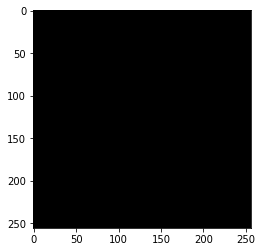

In [4]:
blank_image = np.zeros(shape=(HEIGHT, WIDTH, CHANNELS))

plt.imshow(blank_image)

# Draw rectangles

Note: This will be useful when we want to draw bounding boxes too!

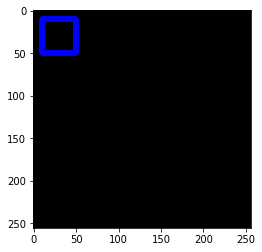

In [5]:
# Draw a rectangle on the blank image
cv2.rectangle(blank_image, pt1=(10, 10), pt2=(50, 50), color=(0, 0, 255), thickness=5)

plt.imshow(blank_image / 255.0)

# Draw circles

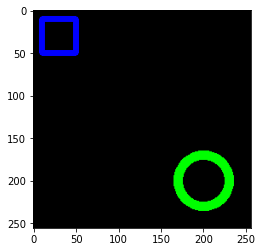

In [6]:
cv2.circle(blank_image, center=(200, 200), radius=30, color=(0, 255, 0), thickness=10)

plt.imshow(blank_image / 255.0)

# Draw Triangles

Or any polygon by just defining more points.

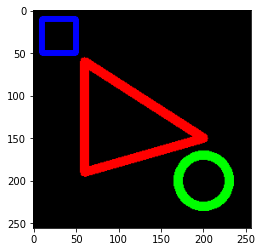

In [7]:
# Each point is a corner of the triangle
# If you add more points, you can get more complex polygons.
pts = [(60, 60), (60, 190), (200, 150)]

cv2.polylines(blank_image, np.array([pts]), True, color=(255, 0, 0), thickness=10)

plt.imshow(blank_image / 255.0)

# Let's write some methods to draw our shapes

This way we can reuse them later for our dataset.

In [8]:
def create_blank(
    height: int = HEIGHT, width: int = WIDTH, channels: int = CHANNELS
) -> np.ndarray:
    """Create an empty image (all black)

    Args:
        height (int): Image height
        width (int): Image width
        channels (int): Image channels (usually 3 for RGB)
        
    Returns:
        np.ndarray of empty (blank) image with desired height, width, and channels
    """

    # Return an empty image
    return np.zeros(shape=(height, width, channels))

In [9]:
def create_shape(img: np.ndarray, shape_type: str) -> np.ndarray:
    """Create circle, rectangle, or triangle

    Overlays the shape onto the image img

    Args:
        img(np.ndarray): The original image
        shape_type(str): A string "rectangle", "circle", or "triangle"

    Returns:
        An image with the shape(s) overlaid on the original input image

    """

    thickness = np.random.randint(2, 10)

    BLUE = (0, 0, 255)
    GREEN = (0, 255, 0)
    RED = (255, 0, 0)

    if shape_type == "rectangle":

        max_width = 60
        left = np.random.randint(img.shape[0] - max_width)
        width = np.random.randint(20, max_width)
        right = left + width

        max_height = 60
        bottom = np.random.randint(img.shape[1] - max_height)
        height = np.random.randint(20, max_height)
        top = bottom + height

        cv2.rectangle(
            img, pt1=(left, bottom), pt2=(right, top), color=BLUE, thickness=thickness
        )

    elif shape_type == "circle":

        center_x = np.random.randint(img.shape[0] // 2 - 30, img.shape[0] // 2 + 30)
        center_y = np.random.randint(img.shape[1] // 2 - 30, img.shape[1] // 2 + 30)
        radius = np.random.randint(20, img.shape[1] // 3)

        cv2.circle(
            img,
            center=(center_x, center_y),
            radius=radius,
            color=GREEN,
            thickness=thickness,
        )

    elif shape_type == "triangle":

        # Each point is in a different quadrant
        pt1 = (
            np.random.randint(thickness + 1, img.shape[0] // 2),
            np.random.randint(thickness + 1, img.shape[1] // 2),
        )
        pt2 = (
            np.random.randint(
                img.shape[0] // 2 + thickness + 1, img.shape[0] - (thickness + 1)
            ),
            np.random.randint(
                img.shape[1] // 2 + thickness + 1, img.shape[1] - (thickness + 1)
            ),
        )

        pt3 = (
            np.random.randint(
                img.shape[0] // 2 + thickness + 1, img.shape[0] - (thickness + 1)
            ),
            np.random.randint(thickness + 1, img.shape[1] // 2 - thickness + 1),
        )

        pts = [pt1, pt2, pt3]

        cv2.polylines(img, np.array([pts]), True, BLUE, thickness=thickness)

    elif shape_type == "pentagon":

        x1 = np.random.randint(int(img.shape[0] * 0.2))
        x2 = np.random.randint(int(img.shape[1] * 0.2))

        p1 = min(img.shape[0], max(0, int(img.shape[0] * 0.15) - x1))
        p2 = min(img.shape[1], max(0, int(img.shape[1] * 0.625) - x2))

        p3 = min(img.shape[0], max(0, int(img.shape[0] * 0.5) - x1))
        p4 = min(img.shape[1], max(0, int(img.shape[1] * 0.4) - x2))

        p5 = min(img.shape[0], max(0, int(img.shape[0] * 0.8) - x1))
        p6 = min(img.shape[1], max(0, int(img.shape[1] * 0.95) - x2))

        p7 = min(img.shape[1], max(0, int(img.shape[0] * 0.33) - x2))

        pt1 = np.array([p1, p2], np.int32)
        pt2 = np.array([p3, p4], np.int32)
        pt3 = np.array([p5, p2], np.int32)
        pt4 = np.array([p2, p6], np.int32)
        pt5 = np.array([p7, p6], np.int32)

        pts = [[pt1, pt2, pt3, pt4, pt5]]

        cv2.polylines(img, np.array(pts), True, RED, thickness=thickness)
        
    else:
        # Shape is unknown
        raise ValueError

    return img / img.max()  # Normalize between 0 and 1

In [10]:
def random_shapes(shapes:List[str]) -> np.ndarray:
    """Create an image with random_shapes
    
    Args:
        A list of strings containing shape names to add to the image.
        
    Returns:
        An image with the specified shapes.
    """
    
    img = create_blank()
    
    for shape in shapes:
        
        create_shape(img, shape) 
        
    return img / img.max()  # Normalize between 0 and 1
        

# create_shape

Creates a blank image with this shape

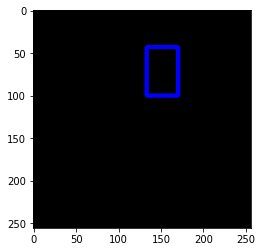

In [11]:
plt.imshow(create_shape(create_blank(), "rectangle"));

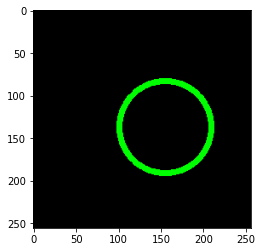

In [12]:
plt.imshow(create_shape(create_blank(), "circle"));

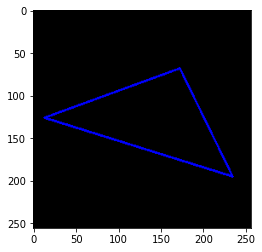

In [13]:
plt.imshow(create_shape(create_blank(), "triangle"));

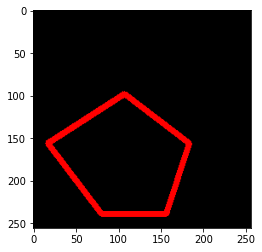

In [14]:
plt.imshow(create_shape(create_blank(), "pentagon"));

# random_shapes

Create an image with a list of random shapes.

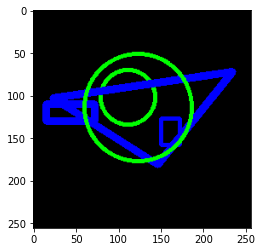

In [15]:
plt.imshow(random_shapes(["circle", "rectangle", "rectangle", "triangle", "circle"]))

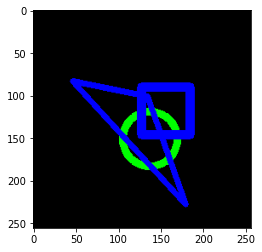

In [16]:
plt.imshow(random_shapes(["circle", "triangle", "rectangle"]))

# Creating the TensorFlow data loader

Dataloaders are essential. We need to create them because typically our entire dataset will *not* fit into RAM. A dataloader allows us to load (and augment) data at the time it is needed for the time it is needed.

In [17]:
import tensorflow as tf

## Define a Python function that can be used in tf.data

We just use the same `random_shapes` Python function that we defined previously. So we are calling OpenCV from Python within TensorFlow. If we need to do any random flips/rotations/crops, then we can do so here as well.

In [18]:
def tf_shapes(n):
    """Return a random shape for the tf.data dataloader

    Args:
        n(int): 0=circle, 1=rectangle, 2=triangle

    Output:
        Image with shape, shape index
    """

    img = random_shapes(list([class_names[n.numpy()]])).astype(np.float32)

    img = tf.reshape(img, [1, HEIGHT, WIDTH, CHANNELS])

    class_num = tf.reshape(n,[1,])

    return img, class_num

## Define a random array of [0, 1, 2] that is n_data in length

In [19]:
n_data = 1000

random_ints = np.random.randint(0, high=len(class_names), size=[n_data,], dtype=np.int32)

## We can use `map` to change the random numbers into images

In [20]:
ds = tf.data.Dataset.from_tensor_slices(random_ints)

ds = ds.map(lambda x: tf.py_function(tf_shapes, [x], [tf.float32, tf.int32]))

# Test the TensorFlow dataloader
 
Let's print out a few random images

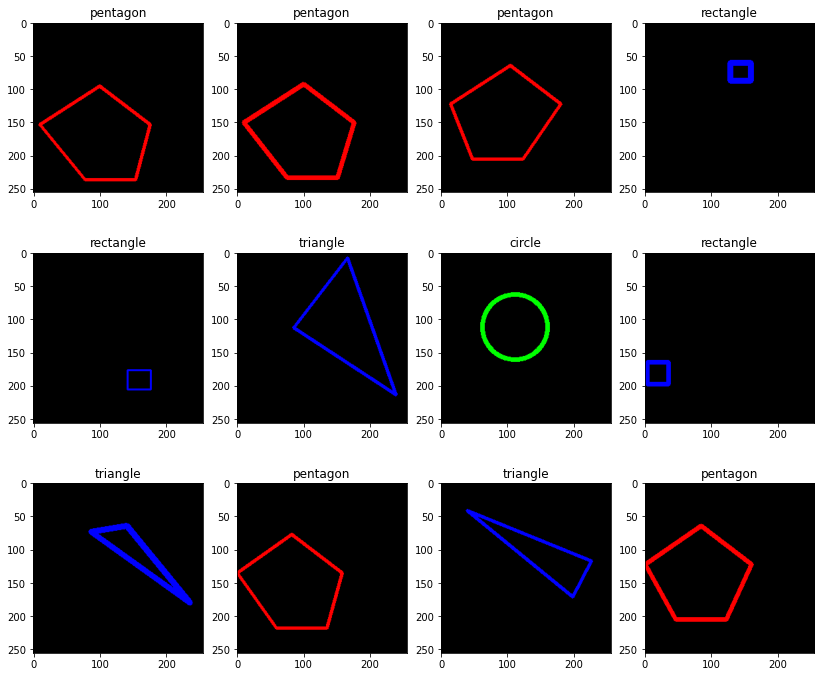

In [21]:
rows = 3
cols = 4

plt.figure(figsize=(14, 12))

for idx, data in enumerate(ds.take(rows * cols)):

    img, class_num = data[0][0], data[1][0]
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(class_names[class_num])

## Define a simple CNN classification model

This is like the CNN classification models that we've seen before. The key differences:
* It has a [Global Average Pooling](https://paperswithcode.com/method/global-average-pooling#:~:text=Global%20Average%20Pooling%20is%20a,in%20the%20last%20mlpconv%20layer.)
* It has [sparse output](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) (i.e. not one-hot encoded)

![globalavgpooling](figures/global_average_pooling.png)

In [22]:
def simple_cnn_classifier():
    """Simple convolutional neural network

    NOTE: The use of GlobalAveragePool2D and Sparse
    NOTE: The None trick is used to define the shape!
    """

    inputs = tf.keras.layers.Input(shape=(None, None, CHANNELS), name="image")

    conv1 = tf.keras.layers.Conv2D(
        filters=16, kernel_size=(3, 3), activation="relu", padding="same"
    )(inputs)
    conv2 = tf.keras.layers.Conv2D(
        filters=11, kernel_size=(3, 3), activation="relu", padding="same"
    )(conv1)

    pool1 = tf.keras.layers.MaxPool2D()(conv2)

    conv3 = tf.keras.layers.Conv2D(
        filters=17, kernel_size=(3, 3), activation="relu", padding="same"
    )(pool1)
    conv4 = tf.keras.layers.Conv2D(
        filters=8, kernel_size=(3, 3), activation="relu", padding="same"
    )(conv3)

    pool2 = tf.keras.layers.MaxPool2D()(conv4)

    conv5 = tf.keras.layers.Conv2D(
        filters=11, kernel_size=(3, 3), activation="relu", padding="same"
    )(pool2)

    # This is the actual sparse layer
    # We don't use an activation layer
    # Therefore, the numbers can be any real number
    # We'll just take the argmax to get the correct prediction
    # This removes the need for a softmax (and one-hot encoding)
    # Save us time and layers!
    conv6 = tf.keras.layers.Conv2D(
        filters=len(class_names), kernel_size=(3, 3), activation=None, padding="same"
    )(conv5)

    # A new layer Global Average Pooling
    # This averages across the channels
    # Makes the model fully-convolutional so it is image size agnostic
    global_pool1 = tf.keras.layers.GlobalAveragePooling2D(name="class_num")(conv6)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[global_pool1])

    return model

In [23]:
model = simple_cnn_classifier()

model.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 image (InputLayer)                                   [(None, None, None, 3)]                         0                 
                                                                                                                        
 conv2d (Conv2D)                                      (None, None, None, 16)                          448               
                                                                                                                        
 conv2d_1 (Conv2D)                                    (None, None, None, 11)                          1595              
                                                                                                                        
 max_pooling2d (M

In [24]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
)

## Split tf dataset into train and validation

Of course, you could split out a testing dataset as well in the same way.

In [25]:
n_train = int(n_data * 0.80)  # 80 / 20 split
ds_train = ds.take(n_train)

ds_remain = ds.skip(n_train)

n_remain = (n_data - n_train) // 2  # 50/50 split
ds_val = ds_remain.take(n_remain)
ds_test = ds_remain.skip(n_remain)

## Train the model

Sparse categorical accuracy goes from 0 (bad) to 1 (perfect) predictions.

In [26]:
model.fit(ds_train, batch_size=64, epochs=5, validation_data=ds_val)

Epoch 1/5
800/800 [==============================] - 61s 75ms/step - loss: 0.9695 - sparse_categorical_accuracy: 0.5600 - val_loss: 0.3696 - val_sparse_categorical_accuracy: 0.7700
Epoch 2/5
800/800 [==============================] - 56s 71ms/step - loss: 0.3050 - sparse_categorical_accuracy: 0.8037 - val_loss: 0.2245 - val_sparse_categorical_accuracy: 0.9700
Epoch 3/5
800/800 [==============================] - 56s 70ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.0784 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
800/800 [==============================] - 60s 74ms/step - loss: 0.0820 - sparse_categorical_accuracy: 0.9762 - val_loss: 0.0709 - val_sparse_categorical_accuracy: 0.9700
Epoch 5/5
800/800 [==============================] - 59s 73ms/step - loss: 0.0470 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.0671 - val_sparse_categorical_accuracy: 0.9700


## Evaluate the trained model on the holdout test dataset

This should be data the model never saw during training nor validation.

In [27]:
loss, accuracy = model.evaluate(ds_test)

print(f"The model is {accuracy*100:.1f}% accurate on the holdout test dataset.")

100/100 [==============================] - 3s 13ms/step - loss: 0.0327 - sparse_categorical_accuracy: 1.0000
The model is 100.0% accurate on the holdout test dataset.


## Make some predictions of new random images based on our trained model

In [28]:
def make_prediction(shape_name: str):
    """Make predictions on the trained model

    Args:
        shape_name(str) : "circle", "rectangle", "triangle"

    Returns:
        Input image and the predicted shape
    """

    img = random_shapes([shape_name])
    plt.imshow(img)

    prediction = np.argmax(model.predict(np.expand_dims(img, 0)))
    plt.title(class_names[prediction])

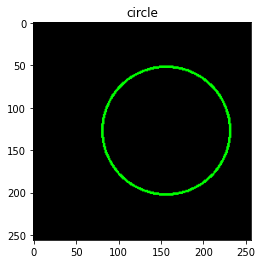

In [29]:
make_prediction("circle")

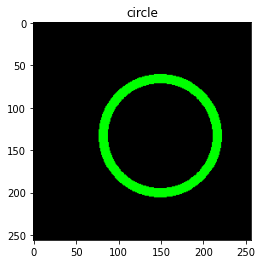

In [30]:
make_prediction("circle")

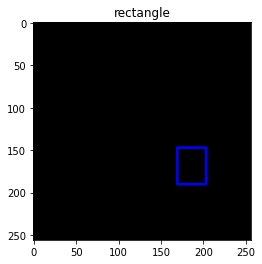

In [31]:
make_prediction("rectangle")

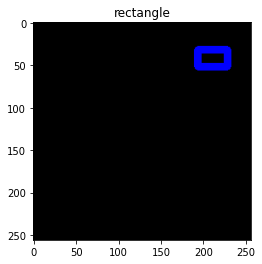

In [32]:
make_prediction("rectangle")

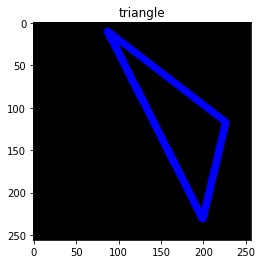

In [33]:
make_prediction("triangle")

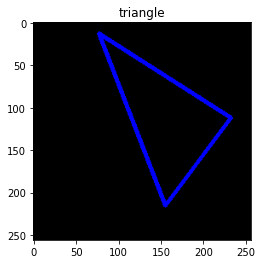

In [34]:
make_prediction("triangle")

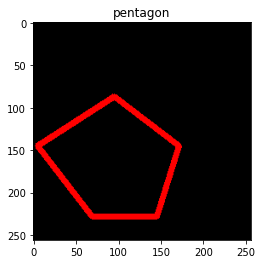

In [35]:
make_prediction("pentagon")

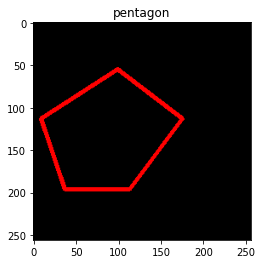

In [36]:
make_prediction("pentagon")

## Will it work with other image sizes?

Yes. Thanks to a fully convolutional network and the `None` shape trick.

Text(0.5, 1.0, 'circle')

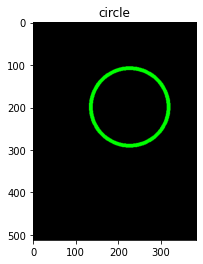

In [37]:
img = create_shape(create_blank(height=512, width=384, channels=3), "circle")

plt.imshow(img)

plt.title(class_names[np.argmax(model.predict(np.expand_dims(img, 0)))])

Text(0.5, 1.0, 'triangle')

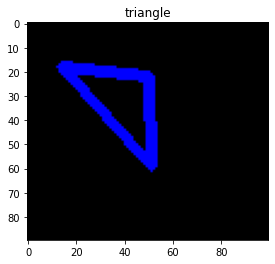

In [38]:
img = create_shape(create_blank(height=90, width=100, channels=3), "triangle")

plt.imshow(img)

plt.title(class_names[np.argmax(model.predict(np.expand_dims(img, 0)))])

Text(0.5, 1.0, 'rectangle')

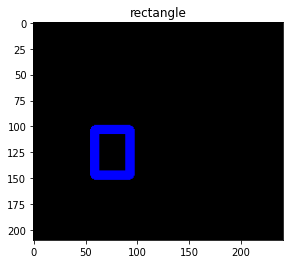

In [39]:
img = create_shape(create_blank(height=210, width=241, channels=3), "rectangle")

plt.imshow(img)

plt.title(class_names[np.argmax(model.predict(np.expand_dims(img, 0)))])

Text(0.5, 1.0, 'pentagon')

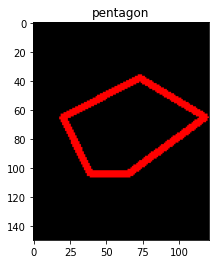

In [40]:
img = create_shape(create_blank(height=150, width=121, channels=3), "pentagon")

plt.imshow(img)

plt.title(class_names[np.argmax(model.predict(np.expand_dims(img, 0)))])

# But where are the bounding boxes?

We have a nice shape classifier, but we were promised a bounding box predictor.

Ok. Let's build on our current code to add that.

## First we need to re-define the data loader to include bounding boxes

So the same code, but we also pass back `[left, bottom, width, height]`

In [41]:
class_names = ["circle", "triangle", "rectangle", "pentagon", "no shape"]

In [42]:
def create_shape_bounding_boxes(img: np.ndarray, shape_type: str) -> np.ndarray:
    """Create circle, rectangle, or triangle

    Overlays the shape onto the image img

    Args:
        img(np.ndarray): The original image
        shape_type(str): A string "rectangle", "circle", or "triangle"

    Returns:
        An image with the shape(s) overlaid on the original input image

    """

    thickness = np.random.randint(2, 10)

    BLUE = (0, 0, 255)
    GREEN = (0, 255, 0)
    RED = (255, 0, 0)

    if shape_type == "rectangle":

        max_width = 60
        left = np.random.randint(img.shape[0] - max_width)
        width = np.random.randint(20, max_width)
        right = left + width

        max_height = 60
        bottom = np.random.randint(img.shape[1] - max_height)
        height = np.random.randint(20, max_height)
        top = bottom + height

        cv2.rectangle(
            img, pt1=(left, bottom), pt2=(right, top), color=BLUE, thickness=thickness
        )
        
       
    
        bounding_box = [left, bottom, width, height]

    elif shape_type == "circle":

        center_x = np.random.randint(img.shape[0] // 2 - 30, img.shape[0] // 2 + 30)
        center_y = np.random.randint(img.shape[1] // 2 - 30, img.shape[1] // 2 + 30)
        radius = np.random.randint(20, img.shape[1] // 3)

        cv2.circle(
            img,
            center=(center_x, center_y),
            radius=radius,
            color=GREEN,
            thickness=thickness,
        )
        
        bounding_box = [center_x-radius, center_y-radius, radius*2, radius*2]

    elif shape_type == "triangle":

        # Each point is in a different quadrant
        pt1 = (
            np.random.randint(thickness + 1, img.shape[0] // 2),
            np.random.randint(thickness + 1, img.shape[1] // 2),
        )
        pt2 = (
            np.random.randint(
                img.shape[0] // 2 + thickness + 1, img.shape[0] - (thickness + 1)
            ),
            np.random.randint(
                img.shape[1] // 2 + thickness + 1, img.shape[1] - (thickness + 1)
            ),
        )

        pt3 = (
            np.random.randint(
                img.shape[0] // 2 + thickness + 1, img.shape[0] - (thickness + 1)
            ),
            np.random.randint(thickness + 1, img.shape[1] // 2 - thickness + 1),
        )

        pts = [pt1, pt2, pt3]

        cv2.polylines(img, np.array([pts]), True, BLUE, thickness=thickness)
        
        left = min([pt1[0], pt2[0], pt3[0]])
        bottom = min([pt1[1], pt2[1], pt3[1]])
        right = max([pt1[0], pt2[0], pt3[0]])
        top = max([pt1[1], pt2[1], pt3[1]])
        
        bounding_box = [left, bottom, right-left, top-bottom]

    elif shape_type == "pentagon":

        x1 = np.random.randint(int(img.shape[0] * 0.2))
        x2 = np.random.randint(int(img.shape[1] * 0.2))

        p1 = min(img.shape[0], max(0, int(img.shape[0] * 0.15) - x1))
        p2 = min(img.shape[1], max(0, int(img.shape[1] * 0.625) - x2))

        p3 = min(img.shape[0], max(0, int(img.shape[0] * 0.5) - x1))
        p4 = min(img.shape[1], max(0, int(img.shape[1] * 0.4) - x2))

        p5 = min(img.shape[0], max(0, int(img.shape[0] * 0.8) - x1))
        p6 = min(img.shape[1], max(0, int(img.shape[1] * 0.95) - x2))

        p7 = min(img.shape[1], max(0, int(img.shape[0] * 0.33) - x2))

        pt1 = np.array([p1, p2], np.int32)
        pt2 = np.array([p3, p4], np.int32)
        pt3 = np.array([p5, p2], np.int32)
        pt4 = np.array([p2, p6], np.int32)
        pt5 = np.array([p7, p6], np.int32)

        pts = [[pt1, pt2, pt3, pt4, pt5]]

        cv2.polylines(img, np.array(pts), True, RED, thickness=thickness)
        
        left = min([pt1[0], pt2[0], pt3[0], pt4[0], pt5[0]])
        bottom = min([pt1[1], pt2[1], pt3[1], pt4[1], pt5[1]])
        right = max([pt1[0], pt2[0], pt3[0], pt4[0], pt5[0]])
        top = max([pt1[1], pt2[1], pt3[1], pt4[1], pt5[1]])
        
        bounding_box = [left, bottom, right-left, top-bottom]
        
    elif shape_type == "no shape":
        
        imgshape = img.shape
        img = np.random.randint(low=0,high=100,size=(imgshape))/100. # Random matrix
        bounding_box = np.array([0,0,0,0]) # No box

    else:
        # Shape is unknown
        raise ValueError
        
    bounding_box = np.array(bounding_box) / img.shape[0]

    return img / img.max(), bounding_box  # Normalize between 0 and 1

In [43]:
def tf_shapes_with_bounding_boxes(n):
    """Return a random shape for the tf.data dataloader

    Args:
        n(int): 0=circle, 1=rectangle, 2=triangle

    Output:
        Image with shape, shape index
    """

    img = create_blank()
    
    img, bounding_box = create_shape_bounding_boxes(img, class_names[n.numpy()])
        
    img = tf.reshape(img.astype(np.float32), [1, HEIGHT, WIDTH, CHANNELS])
    
    bounding_box = tf.reshape(bounding_box.astype(np.float32), [4,])

    class_num = tf.reshape(n, [1,])
    
    if n == (len(class_names) - 1):
        p = 0.0
    else:
        p = 1.0
        
    prob = tf.reshape(p, [1,])

    return img, class_num, bounding_box, prob

In [44]:
ds_bb = tf.data.Dataset.from_tensor_slices(random_ints)

ds_bb = ds_bb.map(lambda x: tf.py_function(tf_shapes_with_bounding_boxes, [x], [tf.float32, tf.int32, tf.float32, tf.float32]))

def wrap_tensors(w,x,y,z):
    """Need to wrap the outputs into a single tuple"""
    return w,(x,y,z)

ds_bb = ds_bb.map(lambda w,x,y,z: wrap_tensors(w,x,y,z))

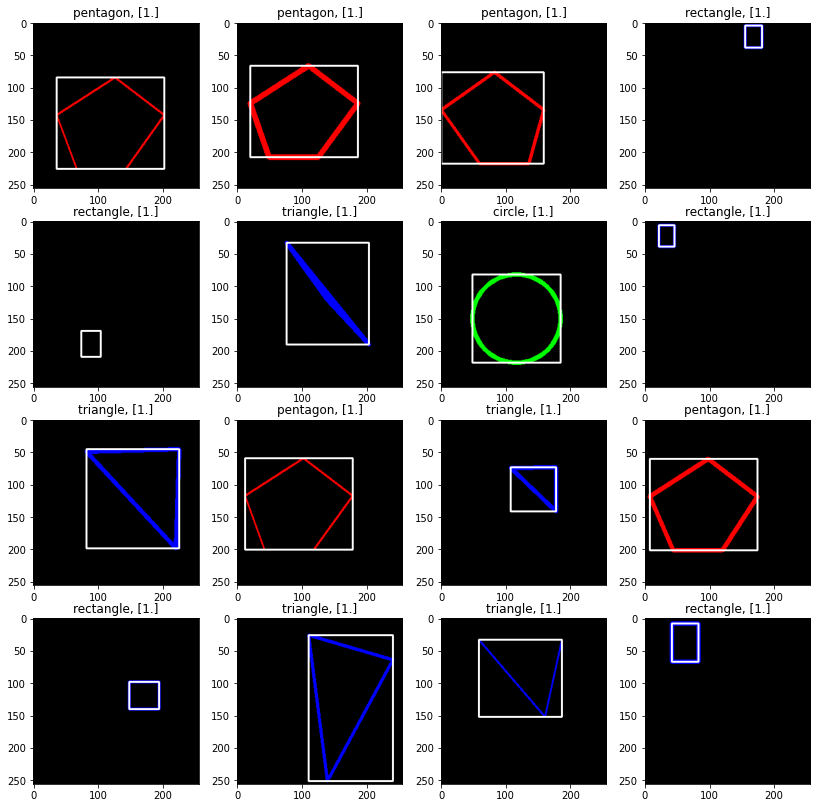

In [45]:
rows = 4
cols = 4

plt.figure(figsize=(14, 14))
idx = 0

for img, data in ds_bb.take(rows * cols):

    class_num, bb, prob = data[0][0], data[1], data[2]

    img_np = img.numpy()[0] * 255.0
    
    bb = bb.numpy() * img_np.shape[0]

    plt.subplot(rows, cols, idx + 1)

    left = int(bb[0])
    bottom = int(bb[1])

    right = left + int(bb[2])
    top = bottom + int(bb[3])

    cv2.rectangle(
        img_np, pt1=(left, bottom), pt2=(right, top), color=(255, 255, 255), thickness=2
    )
    plt.imshow(img_np / img_np.max())
    plt.title(f"{class_names[class_num]}, {prob}")
    
    idx += 1

# Our new CNN network for bounding box predictions
![cnn](figures/bounding_box_tensorflow.png)

In [46]:
def cnn_bounding_box():
    """Convolutional neural network bounding box

    NOTE: The use of GlobalAveragePool2D and Sparse
    NOTE: The None trick is used to define the shape!
    """

    inputs = tf.keras.layers.Input(shape=(None, None, CHANNELS), name="image")

    conv1 = tf.keras.layers.Conv2D(
        filters=16, kernel_size=(3, 3), activation="relu", padding="same"
    )(inputs)
    conv2 = tf.keras.layers.Conv2D(
        filters=11, kernel_size=(3, 3), activation="relu", padding="same"
    )(conv1)

    pool1 = tf.keras.layers.MaxPool2D()(conv2)

    conv3 = tf.keras.layers.Conv2D(
        filters=17, kernel_size=(3, 3), activation="relu", padding="same"
    )(pool1)
    conv4 = tf.keras.layers.Conv2D(
        filters=8, kernel_size=(3, 3), activation="relu", padding="same"
    )(conv3)

    pool2 = tf.keras.layers.MaxPool2D()(conv4)

    conv5 = tf.keras.layers.Conv2D(
        filters=14, kernel_size=(3, 3), activation="relu", padding="same"
    )(pool2)

    # This is the actual sparse layer
    # We don't use an activation layer
    # Therefore, the numbers can be any real number
    # We'll just take the argmax to get the correct prediction
    # This removes the need for a softmax (and one-hot encoding)
    # Save us time and layers!
    conv6 = tf.keras.layers.Conv2D(
        filters=len(class_names), kernel_size=(3, 3), activation=None, padding="same"
    )(conv5)

    # Classification output
    
    # A new layer Global Average Pooling
    # This averages across the channels
    # Makes the model fully-convolutional so it is image size agnostic
    class_num = tf.keras.layers.GlobalAveragePooling2D(name="class_num")(conv6)
    
    
    # Bounding box output
    
    
    conv7 = tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), activation="relu", padding="same"
    )(conv5)
    pool3 = tf.keras.layers.MaxPool2D()(conv7)
    conv8 = tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), activation="relu", padding="same"
    )(pool3)
    conv9 = tf.keras.layers.Conv2D(
        filters=32, kernel_size=(3, 3), activation="relu", padding="same"
    )(conv8)
    
    global_pooling2 = tf.keras.layers.GlobalAveragePooling2D(name="global_pooling2")(conv9)
    
    # Notice we need to have Sigmoid activation because we normalized the box 
    # The 4 represent the 4 bounding box values
    bounding_box = tf.keras.layers.Dense(4, activation="sigmoid", name="bounding_box")(global_pooling2)
    
    probability = tf.keras.layers.Dense(1, activation="sigmoid", name="probability")(global_pooling2)
    
    model = tf.keras.models.Model(inputs=[inputs], outputs=[class_num, bounding_box, probability])

    return model

In [47]:
model = cnn_bounding_box()

## Define losses and metrics for each output

In [76]:
losses = {
    "class_num": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "bounding_box": tf.keras.losses.MeanSquaredError(),
    "probability": tf.keras.losses.BinaryCrossentropy()
}

metrics = {
    "class_num": tf.keras.metrics.SparseCategoricalAccuracy(),
    "bounding_box": tf.keras.metrics.MeanSquaredError(),
    "probability": tf.keras.metrics.Accuracy()
}

In [77]:
model.compile(
    loss=losses,
    metrics=metrics,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
)

In [78]:
model.summary(line_length=120)

Model: "model_1"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image (InputLayer)                    [(None, None, None, 3)]    0             []                                      
                                                                                                                        
 conv2d_6 (Conv2D)                     (None, None, None, 16)     448           ['image[0][0]']                         
                                                                                                                        
 conv2d_7 (Conv2D)                     (None, None, None, 11)     1595          ['conv2d_6[0][0]']                      
                                                                                                                        
 max_pooling2d_

In [79]:
n_train = int(n_data * 0.80)  # 80 / 20 split
ds_bb_train = ds_bb.take(n_train)

ds_bb_remain = ds_bb.skip(n_train)

n_remain = (n_data - n_train) // 2  # 50/50 split
ds_bb_val = ds_bb_remain.take(n_remain)
ds_bb_test = ds_bb_remain.skip(n_remain)

In [80]:
model.fit(ds_bb_train, batch_size=64, epochs=5, validation_data=ds_bb_val)

Epoch 1/5
800/800 [==============================] - 64s 78ms/step - loss: 0.0840 - class_num_loss: 0.0711 - bounding_box_loss: 0.0129 - probability_loss: 0.0000e+00 - class_num_sparse_categorical_accuracy: 0.9675 - bounding_box_mean_squared_error: 0.0129 - probability_accuracy: 1.0000 - val_loss: 0.1316 - val_class_num_loss: 0.1214 - val_bounding_box_loss: 0.0102 - val_probability_loss: 0.0000e+00 - val_class_num_sparse_categorical_accuracy: 0.9600 - val_bounding_box_mean_squared_error: 0.0102 - val_probability_accuracy: 1.0000
Epoch 2/5
800/800 [==============================] - 65s 81ms/step - loss: 0.0689 - class_num_loss: 0.0575 - bounding_box_loss: 0.0114 - probability_loss: 0.0000e+00 - class_num_sparse_categorical_accuracy: 0.9762 - bounding_box_mean_squared_error: 0.0114 - probability_accuracy: 1.0000 - val_loss: 0.0867 - val_class_num_loss: 0.0725 - val_bounding_box_loss: 0.0143 - val_probability_loss: 0.0000e+00 - val_class_num_sparse_categorical_accuracy: 0.9700 - val_bound

In [81]:
model.evaluate(ds_bb_test)

100/100 [==============================] - 3s 13ms/step - loss: 0.1111 - class_num_loss: 0.1017 - bounding_box_loss: 0.0094 - probability_loss: 1.9073e-08 - class_num_sparse_categorical_accuracy: 0.9700 - bounding_box_mean_squared_error: 0.0094 - probability_accuracy: 0.9200


[0.11110186576843262,
 0.1016727089881897,
 0.00942910648882389,
 1.9073491230869877e-08,
 0.9700000286102295,
 0.00942910648882389,
 0.9200000166893005]

In [82]:
def plot_prediction_bb(shape_type: str):
    
    img = create_blank()

    img, bounding_box = create_shape_bounding_boxes(img, shape_type)

    class_logits, predict_box, prob = model.predict(np.expand_dims(img, 0))

    img *= 255.

    predict_box *= img.shape[0]

    left = int(predict_box[0][0])
    bottom = int(predict_box[0][1])

    right = left + int(predict_box[0][2])
    top = bottom + int(predict_box[0][3])

    # Only show box if probability of object in box is greater than threshold
    prob_threshold = 0.7
    if prob > prob_threshold:
        cv2.rectangle(
            img, pt1=(left, bottom), pt2=(right, top), color=(255, 255, 255), thickness=2
        )

    plt.imshow(img / img.max())
    plt.title(f"{class_names[np.argmax(class_logits)]}, {prob[0]}");

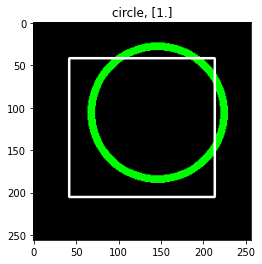

In [83]:
plot_prediction_bb("circle")

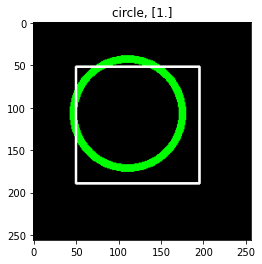

In [84]:
plot_prediction_bb("circle")

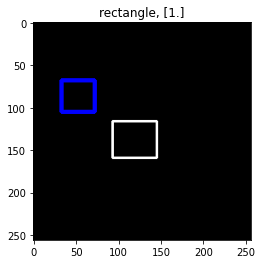

In [85]:
plot_prediction_bb("rectangle")

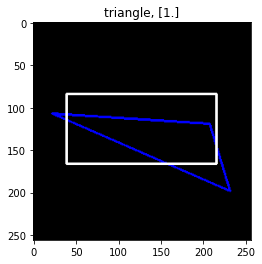

In [86]:
plot_prediction_bb("triangle")

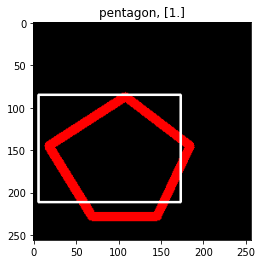

In [87]:
plot_prediction_bb("pentagon")

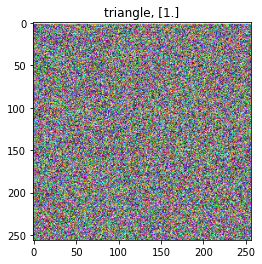

In [88]:
plot_prediction_bb("no shape")